<a href="https://colab.research.google.com/github/Akshatpattiwar512/Convolutional-Neural-Network/blob/main/Mystery_Planet_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download keplersmachines/kepler-labelled-time-series-data

 73% 41.0M/55.9M [00:00<00:00, 67.3MB/s]
100% 55.9M/55.9M [00:00<00:00, 102MB/s] 


In [6]:
! unzip kepler-labelled-time-series-data.zip

Archive:  kepler-labelled-time-series-data.zip
  inflating: exoTest.csv             
  inflating: exoTrain.csv            


## 1D Convolutional Network in Keras

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d

In [8]:
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

## Data Loading

In [9]:
INPUT_LIB = '../content/'
raw_data = np.loadtxt(INPUT_LIB + 'exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt(INPUT_LIB + 'exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

Scale each observation to zero mean and unit variance.

In [10]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [11]:
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

## Model Training

In [12]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [13]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [14]:
model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


In [15]:
model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=x_train.shape[1]//32)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
99/99 - 11s - loss: 0.7068 - accuracy: 0.5480 - val_loss: 0.6799 - val_accuracy: 0.5789
Epoch 2/40
99/99 - 8s - loss: 0.6911 - accuracy: 0.5707 - val_loss: 0.6748 - val_accuracy: 0.6035
Epoch 3/40
99/99 - 8s - loss: 0.6961 - accuracy: 0.5657 - val_loss: 0.6701 - val_accuracy: 0.6246
Epoch 4/40
99/99 - 8s - loss: 0.6832 - accuracy: 0.5814 - val_loss: 0.6770 - val_accuracy: 0.6035
Epoch 5/40
99/99 - 8s - loss: 0.6684 - accuracy: 0.5975 - val_loss: 0.6568 - val_accuracy: 0.6561
Epoch 6/40
99/99 - 8s - loss: 0.6661 - accuracy: 0.5922 - val_loss: 0.6592 - val_accuracy: 0.6544
Epoch 7/40
99/99 - 8s - loss: 0.6617 - accuracy: 0.6136 - val_loss: 0.6408 - val_accuracy: 0.6772
Epoch 8/40
99/99 - 8s - loss: 0.6390 - accuracy: 0.6326 - val_loss: 0.6443 - val_accuracy: 0.6667
Epoch 9/40
99/99 - 8s - loss: 0.6414 - accuracy: 0.6471 - val_loss: 0.6167 - val_accuracy: 0.7088
Epoch 10/40
99/99 - 8s - loss: 0.6290 - accuracy: 0.6471 - val_loss: 0.6165 - val_accuracy: 0.7105
Epoch 11/40
99/99 

## Model Evaluation

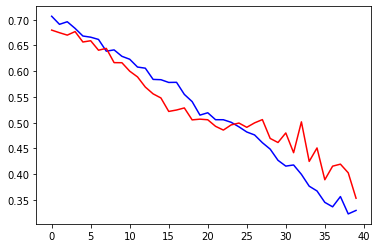

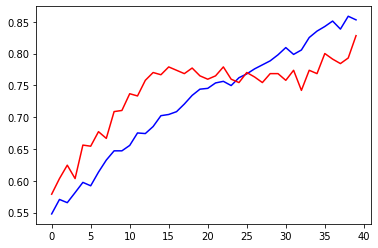

In [18]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.show()

In [19]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]

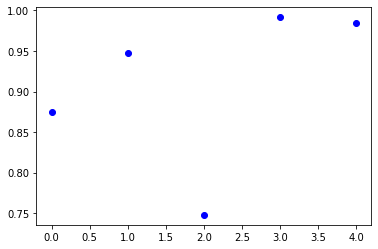

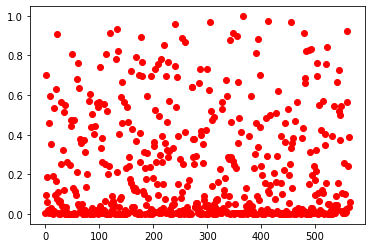

In [20]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

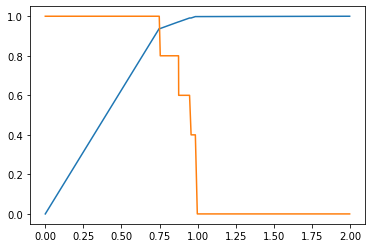

Crossover at 0.75 with specificity 0.94


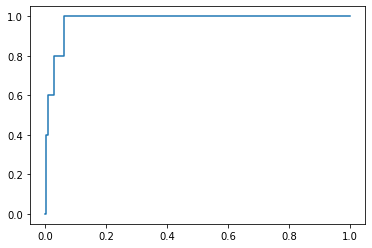

ROC area under curve is 0.98


In [21]:
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

27


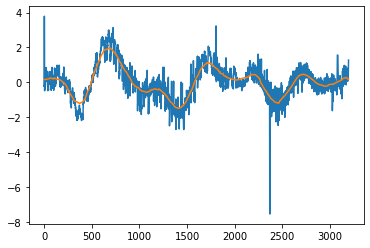

54


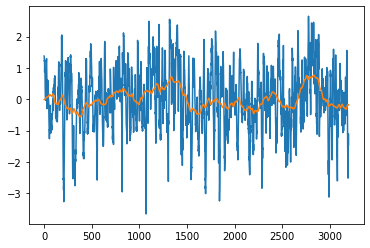

65


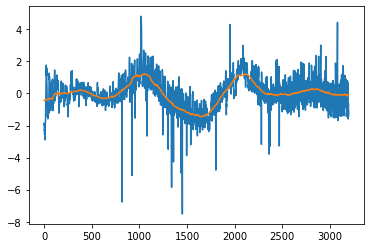

117


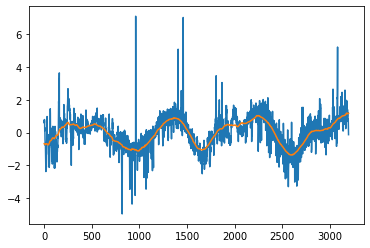

124


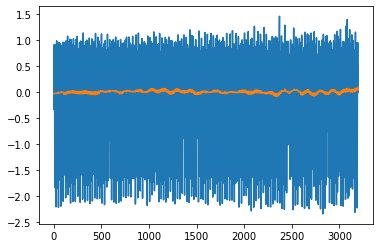

136


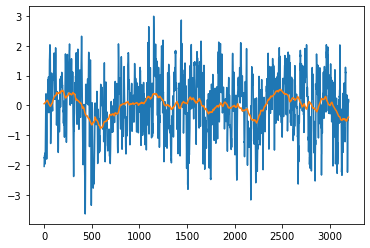

137


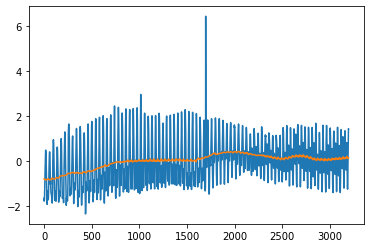

139


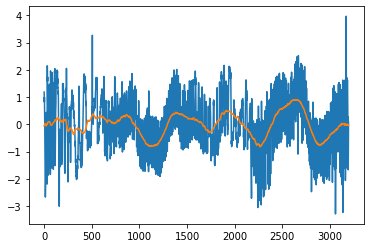

173


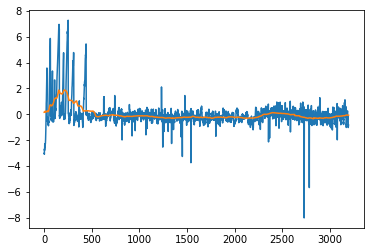

183


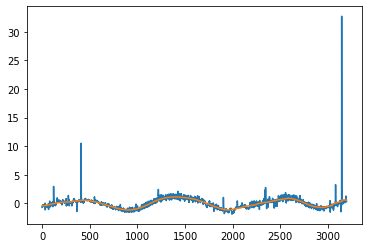

184


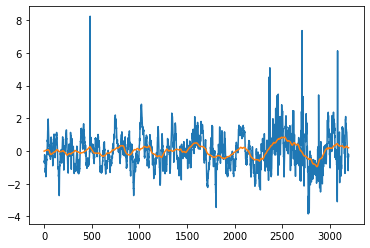

214


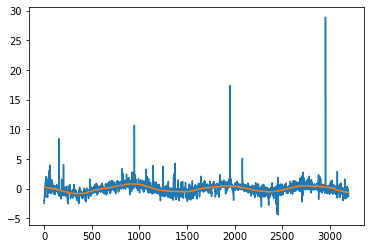

220


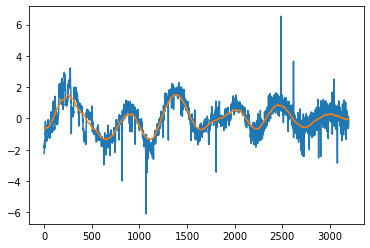

225


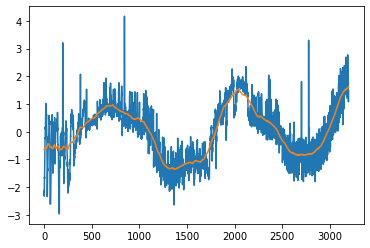

233


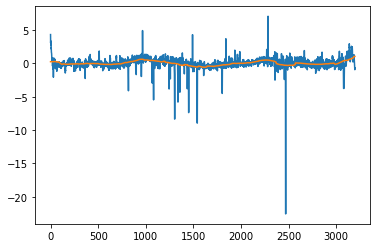

246


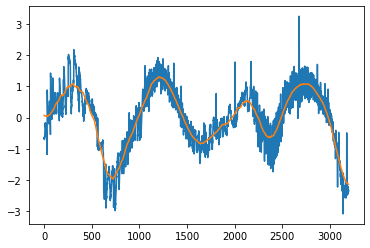

258


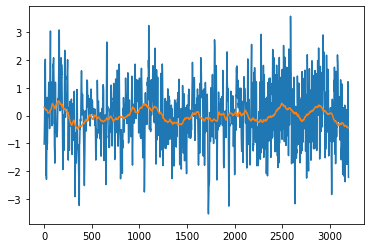

263


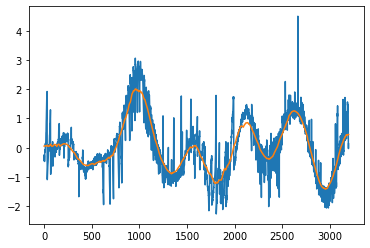

310


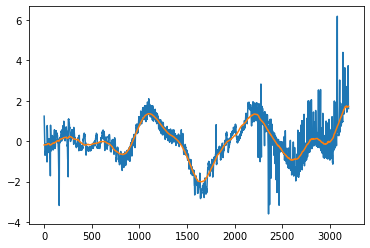

347


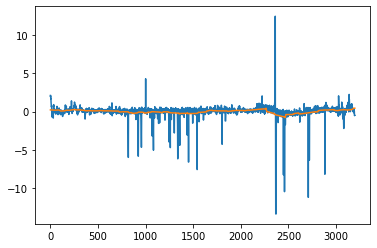

352


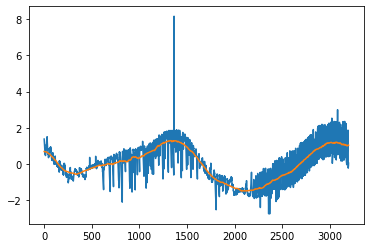

360


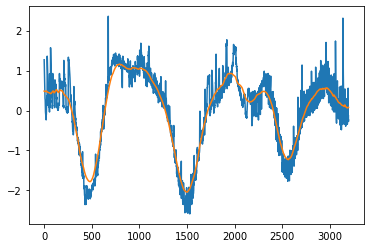

372


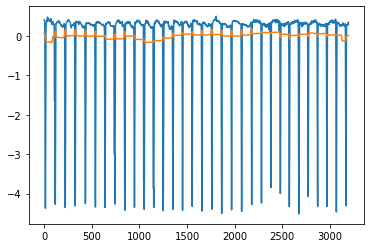

395


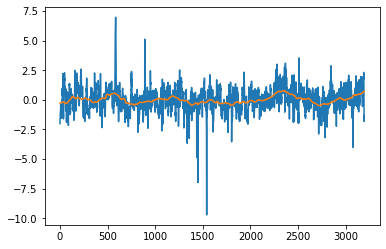

400


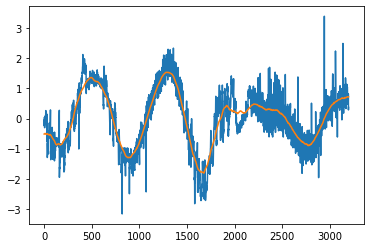

417


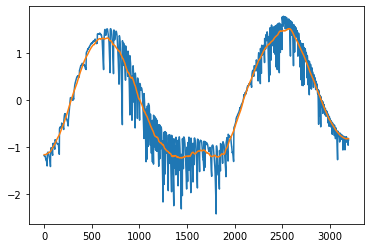

460


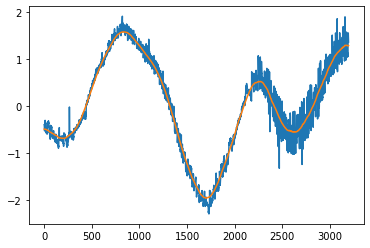

485


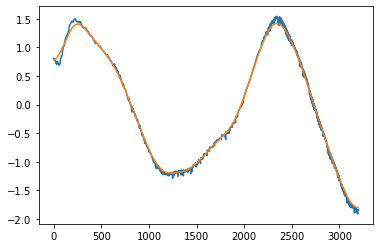

488


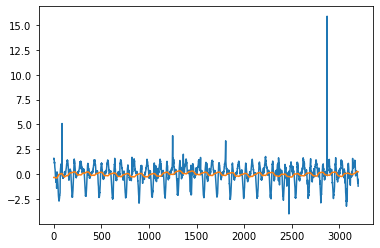

493


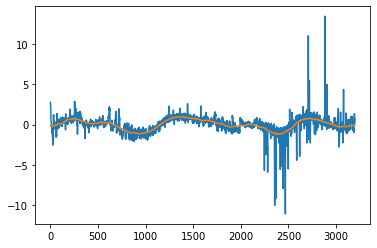

498


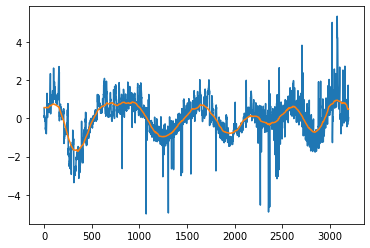

508


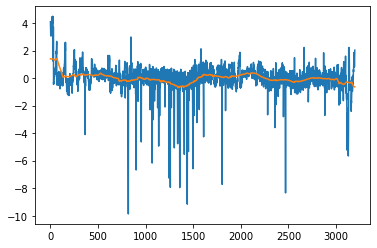

526


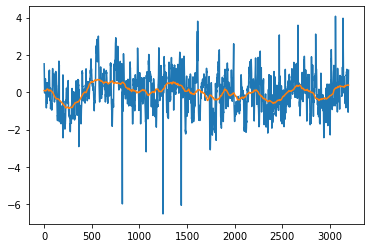

527


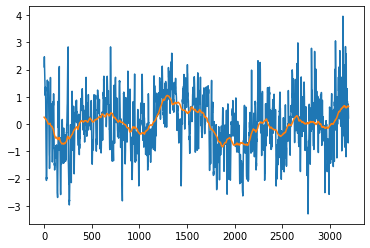

565


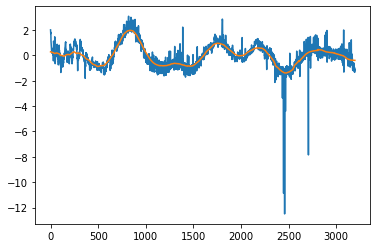

In [22]:
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.show()